In [1]:
import datetime
import numpy as np
import pandas as pd
from rdflib import Graph
import time

from viscars.data import DataLoader
from viscars.evaluation.evaluators.kfoldcv import KFoldCrossValidation
from viscars.evaluation.metrics import MetricType
from viscars.evaluation.metrics.factory import MetricFactory
from viscars.recommenders.factory import RecommenderFactory, RecommenderType
from viscars.utils import visualize_graph

In [2]:
project = 'proeftuin'

graph = Graph()
graph.parse(f'./data/{project}/graph.ttl', format='n3')
d_loader = DataLoader(graph)

factory = RecommenderFactory()
recommender = factory.get(RecommenderType.PPR)(d_loader.load_graph())

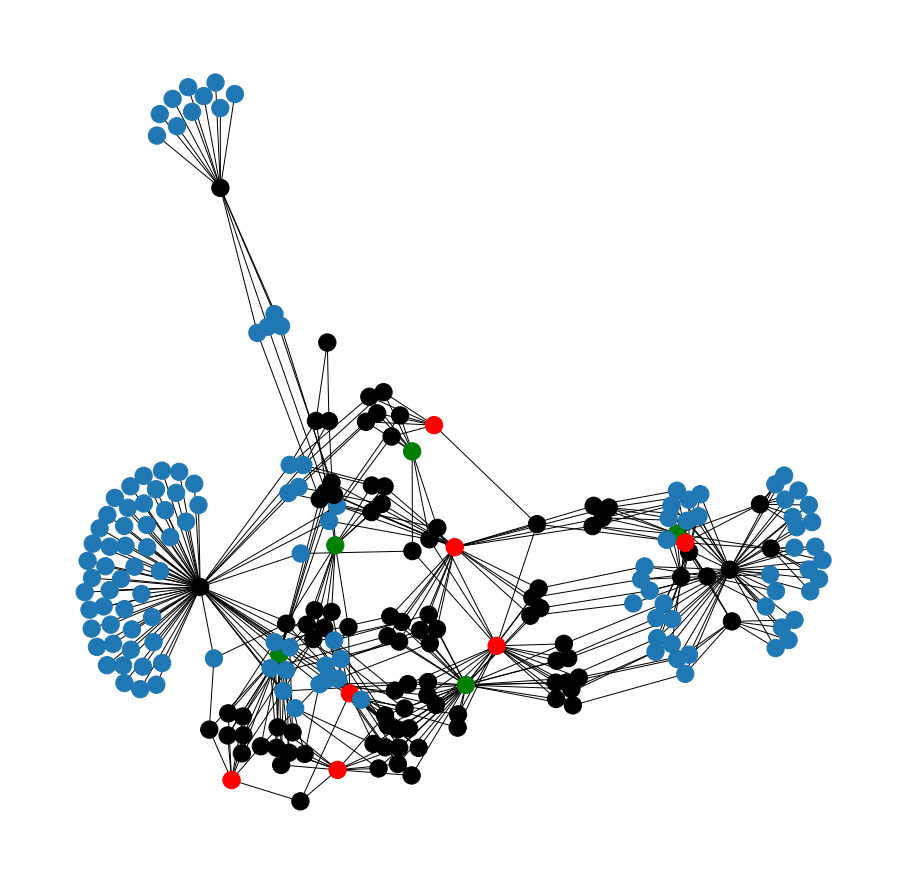

In [3]:
visualize_graph(recommender.graph, colored=True, save=True)

## GridSearchCV

In [4]:
start = time.time()

metric_factory = MetricFactory()
recommender_factory = RecommenderFactory()

params = {
    'alpha': np.divide(list(range(0, 10, 1)), 10),
    'weight_uid': np.divide(list(range(0, 11, 1)), 10),
    'weight_cid': np.divide(list(range(0, 11, 1)), 10)
}
metrics = ['ndcg@1']
parsed_metrics = []
for metric in metrics:
    m_split = metric.split('@')
    m_type = m_split[0]
    n = int(m_split[1]) if len(m_split) >= 2 else None

    metric_ = metric_factory.get(MetricType.reverse_lookup(m_type), n)
    parsed_metrics.append(metric_)

recommenders = [r for r in RecommenderType]
recommenders.remove(RecommenderType.RANDOM)

for recommender in recommenders:
    results = pd.DataFrame(columns=list(params.keys()).extend(metrics))
    print(f'[{datetime.timedelta(seconds=(time.time()-start))}] Running GridSearchCV for {recommender}')
    for alpha in params['alpha']:
        print(f'[{datetime.timedelta(seconds=(time.time()-start))}] Running GridSearchCV for alpha={alpha}')

        if recommender == RecommenderType.PAGERANK:
                r = recommender_factory.get(recommender)(d_loader.load_graph(), alpha)

                evaluator = KFoldCrossValidation('proeftuin', r, metrics=parsed_metrics)
                result = evaluator.evaluate()

                row = {'alpha': alpha}
                row.update(result['result'])
                results = results.append(row, ignore_index=True)
        else:
            for wuid in params['weight_uid']:
                for wcid in params['weight_cid']:
                    if wuid + wcid <= 1:
                        r = recommender_factory.get(recommender)(d_loader.load_graph(), alpha)
                        r.set_personalization(wuid, wcid)

                        evaluator = KFoldCrossValidation('proeftuin', r, metrics=parsed_metrics)
                        result = evaluator.evaluate()

                        row = {'alpha': alpha, 'weight_uid': wuid, 'weight_cid': wcid}
                        row.update(result['result'])
                        results = results.append(row, ignore_index=True)

    end = time.time()
    print(f'GridSearchCV completed in {datetime.timedelta(seconds=(end-start))}')

    for metric in metrics:
        print(metric)
        print(results[results[metric] == results[metric].max()])

[0:00:00.001502] Running GridSearchCV for RecommenderType.PAGERANK
[0:00:00.002005] Running GridSearchCV for alpha=0.0
[0:00:01.618502] Running GridSearchCV for alpha=0.1
[0:00:03.144505] Running GridSearchCV for alpha=0.2
[0:00:04.720004] Running GridSearchCV for alpha=0.3
[0:00:06.227505] Running GridSearchCV for alpha=0.4
[0:00:07.746505] Running GridSearchCV for alpha=0.5
[0:00:09.319501] Running GridSearchCV for alpha=0.6
[0:00:10.825000] Running GridSearchCV for alpha=0.7
[0:00:12.330003] Running GridSearchCV for alpha=0.8
[0:00:13.914505] Running GridSearchCV for alpha=0.9
GridSearchCV completed in 0:00:15.435004
ndcg@1
   alpha    ndcg@1
1    0.1  0.449673
7    0.7  0.449673
[0:00:15.441501] Running GridSearchCV for RecommenderType.PPR
[0:00:15.441501] Running GridSearchCV for alpha=0.0


ZeroDivisionError: 